In [1]:
import collections
import numpy as np
import scipy.optimize

tax_rates = [
    (9700, 0.10),
    (39475, 0.12),
    (84200, 0.22),
    (160725, 0.24),
    (204100, 0.32),
    (510300, 0.35),
    (1000**5, 0.37)
]

ca_tax_rates = [
    (8544, 0.01),
    (20255, 0.02),
    (31969, 0.04),
    (44377, 0.06),
    (56085, 0.08),
    (286492, 0.093),
    (343788, 0.103),
    (572980, 0.113),
    (1000**5, 0.123)
]

example_tax_rates = [ # Example 4% on some income, just because, representing some arbitrary state that's not CA
    (10000, 0.01),
    (40000, 0.02),
    (80000, 0.03),
    (1000**5, 0.04)
]

def incometax(pretax_income_arg, state_tax=[]):
    if isinstance(pretax_income_arg, collections.Iterable):
        return [incometax(i, state_tax=state_tax) for i in pretax_income_arg]
    tax_owed = 0
    previous_end = 0
    pretax_income = pretax_income_arg - 12200 # Standard Exemption
    for end, rate in tax_rates:
        money_in_bracket = max(min(pretax_income - previous_end, end - previous_end),0)
        tax_owed = tax_owed + money_in_bracket * rate
        previous_end = end
    for end, rate in state_tax:
        money_in_bracket = max(min(pretax_income - previous_end, end - previous_end),0)
        tax_owed = tax_owed + money_in_bracket * rate
        previous_end = end
    return round(tax_owed,0)

def posttax(pretax_income_arg, state_tax=[]):
    if isinstance(pretax_income_arg, collections.Iterable):
        return [posttax(i, state_tax=state_tax) for i in pretax_income_arg]
    return round(pretax_income_arg - incometax(pretax_income_arg, state_tax=state_tax),0)

def pretax(posttax_income, state_tax=[]):
    if isinstance(posttax_income, collections.Iterable):
        return [pretax(i, state_tax=state_tax, quiet=quiet) for i in posttax_income]
    pretax_error = lambda pretax_income : posttax(pretax_income, state_tax=state_tax) - posttax_income
    # Use a Brent gradient approach method of solving roots to determine the proper value
    pretax_income = scipy.optimize.brentq(pretax_error, 0, posttax_income * 100)
    return round(pretax_income,1)

    

In [2]:
import matplotlib.pyplot as plt

pretax_income = np.arange(0, 350 * 1000, 10 * 1000)
posttax_income = posttax(pretax_income)

print('Pretax Income ranging from {} to {}'.format(pretax_income[0], pretax_income[-1]))

fig, ax = plt.subplots()
plt.plot(pretax_income, posttax(pretax_income, state_tax=[]), 'og', ms=5, label='2019 Federal Tax Rates (Single Filer)')
plt.plot(pretax_income, posttax(pretax_income, state_tax=ca_tax_rates), 'xb', ms=5, label='2019 Federal+CA Tax Rates')
plt.plot(pretax_income, pretax_income, '-r', ms=4, label='Assuming No Tax')
plt.axis([0,pretax_income[-1],0,pretax_income[-1]])
ax.legend()
ax.set_xlabel('PreTax Income ($)')
ax.set_ylabel('PostTax Income ($)')
plt.grid()

plt.show()


Pretax Income ranging from 0 to 340000


<Figure size 640x480 with 1 Axes>

Pretax Income ranging from 75000 to 345000
Avg approx error is 0.0038
Polynomial terms are [-4.94658938e-07  8.94934191e-01]


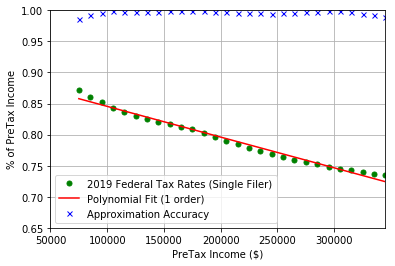

In [3]:
pretax_income = np.arange(75 * 1000, 350 * 1000, 10 * 1000)
posttax_income = posttax(pretax_income)
posttax_income_as_percent = posttax_income/pretax_income
polyfit_order = 1
approx_percent_polynom = np.poly1d(np.polyfit(pretax_income, posttax_income/pretax_income, polyfit_order))
approx_percent = approx_percent_polynom(pretax_income)
approximation_error = [abs(x-y) for x, y  in zip(approx_percent, posttax_income_as_percent)]
avg_approx_error = np.average(approximation_error)
approximation_accuracy = [1-x for x in approximation_error]

print('Pretax Income ranging from {} to {}'.format(pretax_income[0], pretax_income[-1]))
print('Avg approx error is {:.2}'.format(avg_approx_error))
print('Polynomial terms are {}'.format(np.asarray(approx_percent_polynom)))

fig, ax = plt.subplots()
plt.plot(pretax_income, posttax_income_as_percent, 'og', ms=5, label='2019 Federal Tax Rates (Single Filer)')
plt.plot(pretax_income, approx_percent, '-r', ms=5, label='Polynomial Fit ({} order)'.format(polyfit_order))
plt.plot(pretax_income, approximation_accuracy, 'xb', ms=5, label='Approximation Accuracy')
plt.axis([50000,pretax_income[-1],0.65,1])
ax.legend()
ax.set_xlabel('PreTax Income ($)')
ax.set_ylabel('% of PreTax Income')
plt.grid()
plt.show()


In [75]:
import sys
class RecurringCashflow:
    def define_monthly(self, monthly_flow, name, monthly_nw=0, yearly_apr=1.0, year_start=0, year_end=sys.maxsize, taxable=False):
        self.define_yearly(monthly_flow * 12, name, monthly_nw*12, yearly_apr, year_start, year_end, taxable)
        return self
        
    def define_yearly(self, yearly_flow, name, yearly_nw=0, yearly_apr=1.0, year_start=0, year_end=sys.maxsize, taxable=False):
        self.yearly_flow = yearly_flow
        self.name = name
        self.yearly_nw = yearly_nw
        self.yearly_apr = yearly_apr
        self.year_start = year_start
        self.year_end = year_end
        self.taxable = taxable # Specified if this impacts your AGI - Salary and 401k, for example, are both 'taxable', 
                               # in that the 401k expense is negative taxable income
        return self
    
    def cashflow(self, year):
        if year >= self.year_start and year <= self.year_end:
            years_accumulated = year - self.year_start
            return self.yearly_flow * (self.yearly_apr**years_accumulated)
        else:
            return 0
        
    def gross_income(self, year):
        if year >= self.year_start and year <= self.year_end and self.yearly_flow > 0:
            years_accumulated = year - self.year_start
            return self.yearly_flow * (self.yearly_apr**years_accumulated)
        else:
            return 0
    
    def taxable_amount(self, year):
        if year >= self.year_start and year <= self.year_end and self.taxable:
            years_accumulated = year - self.year_start
            return self.yearly_flow * (self.yearly_apr**years_accumulated)
        else:
            return 0
    
    def expenses(self, year):
        if year >= self.year_start and year <= self.year_end and self.yearly_flow < 0:
            years_accumulated = year - self.year_start
            return self.yearly_flow * (self.yearly_apr**years_accumulated)
        else:
            return 0
    
    def nwflow(self, year):
        if year >= self.year_start and year <= self.year_end:
            years_accumulated = year - self.year_start
            return self.yearly_nw * (self.yearly_apr**years_accumulated)
        else:
            return 0

        
class CashflowModel():
    def __init__(self, name='Unnamed', state_tax=[]):
        self.cashflows = []
        self.name = name
        self.state_tax=state_tax
        
    def add_recurring_cashflow(self, recurring_cashflow):
        self.cashflows.append(recurring_cashflow)
        
    def add_monthly(self, *args, **kwargs):
        rc = RecurringCashflow().define_monthly(*args, **kwargs)
        self.add_recurring_cashflow(rc)
        
    def add_yearly(self, *args, **kwargs):
        rc = RecurringCashflow().define_yearly(*args, **kwargs)
        self.add_recurring_cashflow(rc)
        
    def get_cashflow(self, year):
        return sum([x.cashflow(year) for x in self.cashflows])
    
    def get_gross_income(self, year):
        return sum([x.gross_income(year) for x in self.cashflows])
    
    def get_taxable_income(self, year):
        return max(0,sum([x.taxable_amount(year) for x in self.cashflows]))
    
    def get_expenses(self, year):
        return sum([x.expenses(year) for x in self.cashflows])
        
    def get_nwflow(self, year):
        return sum([x.nwflow(year) for x in self.cashflows])
    
    def plot_annual_flow(self, year=0):
        fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
        axs = plt.subplot(1,2,1)
        cashflow_list = [(x.expenses(year)) for x in self.cashflows]
        cashflow_labels = [x.name + '(${})'.format(int(y)) if y != 0 else '' for x,y in zip(self.cashflows, cashflow_list)]
        plt.pie(np.absolute(cashflow_list), labels=cashflow_labels)
        plt.title('Net Annual Expenses (${})'.format(self.get_expenses(year)))
        axs = plt.subplot(1,2,2)
        nwflow_list = [x.nwflow(year) for x in self.cashflows]
        #nwflow_labels = [x.name +' (${})'.format(int(x.nwflow(year))) if x.yearly_nw != 0 else '' for x in self.cashflows]
        nwflow_labels = [x.name + '(${})'.format(int(y)) if y != 0 else '' for x,y in zip(self.cashflows,nwflow_list)]
        plt.pie(nwflow_list, labels=nwflow_labels)
        plt.title('Yearly NW Flow (${})'.format(int(sum([x.nwflow(year) for x in self.cashflows]))))
        plt.suptitle('Annual Cashflows for $\it{}$'.format(self.name))
        plt.show()
        
    def plot_monthly_flow(self, year=0):
        fig, axs = plt.subplots(1,2,figsize=(14,6), constrained_layout=True)
        axs = plt.subplot(1,2,1)
        cashflow_list = [int(x.cashflow(year)/12) for x in self.cashflows]
        cashflow_labels = [x.name + '(${})'.format(int(y/12)) if y != 0 else '' for x,y in zip(self.cashflows, cashflow_list)]
        plt.pie(np.absolute(cashflow_list), labels=cashflow_labels)
        plt.title('Net Monthly Cashflows (${})'.format(int(self.get_cashflow(year)/12)))
        plt.title('Monthly Cashflows (${})'.format(int(self.get_cashflow(year)/12)))
        axs = plt.subplot(1,2,2)
        monthly_nwflow_list = [x.nwflow(year)/12 for x in self.cashflows]
        monthly_nwflow_labels = [x.name + '(${})'.format(int(y)) if y != 0 else '' for x,y in zip(self.cashflows,monthly_nwflow_list)]
        plt.pie(monthly_nwflow_list, labels=monthly_nwflow_labels)
        plt.title('Monthly NW Flow (${})'.format(int(sum(monthly_nwflow_list))))
        plt.suptitle('Monthly Cashflows for $\it{}$'.format(self.name))
        plt.show()




In [86]:
import pandas as pd
import copy
import time

# We create a list of dictionaries, where each entry/dict is one row

class FinancialModel:
    # A Financial Model takes in initial conditions and a CashflowModel, creating a time history of key metrics:
    # Total Net Worth, Annual Outflows, Annual NW Increase, Annual Pretax Required, and Year ID
    # These are returned in a dataframe by 'sim', then passed to plotting/analysis/stored
    # In any given year, if income > expenses, the difference is added to net worth
    
    def __init__(self, year=0, max_nw=8*1000*1000):
        self.year=year
        self.max_nw = max_nw
    
    def sim_basic(self, cashflowmodel, nyears=30, initial_nw=0, nw_apr=1.075494565):
        return self.sim(cashflowmodel, nyears=nyears, initial_nw=initial_nw, nw_apr_avg=nw_apr, nw_apr_stdev=0, nruns=1)

    # Default nw APR and stdev are taken from S&P actual returns, 1928->2019
    def sim(self, cashflowmodel, nyears=30, initial_nw=0, nw_apr_avg=1.075494565, nw_apr_stdev=0.189442643, nruns=100):
        sim_run_dfs = []
        df_summary = {}
        df_summary['name'] = ('{}+{} @ {}+/-{} for {} yrs'.format(cashflowmodel.name, initial_nw, round(nw_apr_avg,3), round(nw_apr_stdev,3), nyears))
        print('Starting sim for {} ...'.format(df_summary['name']), end=' ')
        start_time = time.monotonic()
        for run in np.arange(0,nruns): # should use >= 100 runs for some statistical interest
            this_year = {}
            this_year['NetWorthInterest'] = 0
            this_year['NetWorth'] = initial_nw
            this_year['GrossIncome'] = 0
            this_year['TaxableIncome'] = 0
            this_year['Expenses'] = 0
            this_year['IncomeTax'] = 0
            this_year['ExplicitNWGrowth'] = 0
            this_year['ExcessCash'] = 0
            this_year['nw_apr'] = 1.0
            this_year['Year ID'] = 0
            year = []
            year.insert(0,copy.deepcopy(this_year))
            last_year = year[0]
            #years.append(copy.deepcopy(last_year))
            for current_year_id in np.arange(1,nyears):
                # Each year, we increase our networth by some percentage due to asset appreciation
                # We do not (yet) modify or alter our outflows, annual nw increase, or pretax required
                nw_apr = np.random.normal(loc = nw_apr_avg, scale = nw_apr_stdev, size = 1)[0]
                this_year = {}
                this_year['NetWorthInterest'] = int(last_year.get('NetWorth',0) * (nw_apr-1.0))
                this_year['NetWorth'] = min(self.max_nw, int(last_year['NetWorth'] + this_year['NetWorthInterest'] + last_year.get('ExplicitNWGrowth',0) + last_year.get('ExcessCash',0)))
                this_year['GrossIncome'] = int(cashflowmodel.get_gross_income(current_year_id))
                this_year['TaxableIncome'] = int(cashflowmodel.get_taxable_income(current_year_id))
                this_year['Expenses'] = int(cashflowmodel.get_expenses(current_year_id))
                this_year['IncomeTax'] = int(incometax(this_year['TaxableIncome'], cashflowmodel.state_tax))
                this_year['ExplicitNWGrowth'] = int(cashflowmodel.get_nwflow(current_year_id))
                this_year['ExcessCash'] = int(this_year['GrossIncome'] + this_year['Expenses'] - this_year['IncomeTax'])
                this_year['nw_apr'] = nw_apr
                this_year['Year ID'] = current_year_id
                year.insert(current_year_id,copy.deepcopy(this_year))
                last_year = year[current_year_id]
            sim_run_dfs.append(pd.DataFrame(year))
        # We now have a list of DataFrames to process... 
        all_dfs = pd.concat(sim_run_dfs)
        year_summary = {}
        years = []
        for current_year_id in np.arange(1, nyears):
            this_years_rows = [df.loc[df['Year ID'] == current_year_id] for df in sim_run_dfs]
            this_years_rows = pd.concat(this_years_rows)
            dict_keys = ['NetWorthInterest', 'NetWorth', 'GrossIncome', 'TaxableIncome', 'Expenses', 'IncomeTax', 'ExplicitNWGrowth', 'ExcessCash', 'nw_apr', 'Year ID']
            for dk in dict_keys:
                year_summary[dk] = np.mean(this_years_rows[dk])
                year_summary[dk+':STDEV:top'] = np.mean(this_years_rows[dk]) + np.std(this_years_rows[dk])
                year_summary[dk+':STDEV:bottom'] = np.mean(this_years_rows[dk]) - np.std(this_years_rows[dk])
                year_summary[dk+':0.80:top'] = np.percentile(this_years_rows[dk],90)
                year_summary[dk+':0.80:bottom'] = np.percentile(this_years_rows[dk],10)
            this_year = copy.deepcopy(year_summary)
            years.append(this_year)
        df_summary['nyears'] = nyears
        df_summary['initial_nw'] = initial_nw
        df_summary['nw_apr'] = nw_apr_avg
        df_summary['nw_apr_stdev'] = nw_apr_stdev
        print('Finished in {} seconds'.format(round(time.monotonic()-start_time,1)))
        return (pd.DataFrame(years), df_summary)
    
    def plot(self, df_tuple, suffix=':STDEV'):
        fig, axs = plt.subplots(2,3,figsize=(17,9), constrained_layout=False)
        if isinstance(df_tuple, list):
            df_tuple_list = df_tuple
        else:
            df_tuple_list = [df_tuple]
        fields_to_plot = ['NetWorth', 'NetWorthInterest', 'ExplicitNWGrowth', 'TaxableIncome', 'Expenses', 'ExcessCash']
        cur_ax_id = 0
        for field in fields_to_plot:
            ax = axs.flat[cur_ax_id]
            cur_ax_id = cur_ax_id + 1
            for df, df_summary in df_tuple_list:
                top_bottom_differences = [t-b for t,b in zip(df[field+suffix+':top'],df[field+suffix+':bottom'])]
                should_plot_error_bars = True if np.max(top_bottom_differences) > 1000 else False
                #print('For {} in {}, speb is {} due to {}'.format(field+suffix, df_summary['name'], should_plot_error_bars,np.max(top_bottom_differences)))
                if should_plot_error_bars:
                    thisplot = ax.plot(df['Year ID']+self.year, df[field]/1000, '-', label='{}'.format(df_summary['name']))
                    thisplot_color = thisplot[0].get_color()
                    top_bar = [t/1000 for t in df[field+suffix+':top']]
                    bottom_bar = [b/1000 for b in df[field+suffix+':bottom']]
                    ax.fill_between(df['Year ID']+self.year, bottom_bar, top_bar, color=thisplot_color, alpha=0.2)
                else:
                    ax.plot(df['Year ID']+self.year, df[field]/1000, label='{}'.format(df_summary['name']))
                handles, labels = ax.get_legend_handles_labels()
            ax.set_xlim(left=self.year)
            #ax.set_ylim(bottom=0)
            if self.year is 0:
                ax.set_xlabel('Years Since Initial Conditions')
            else:
                ax.set_xlabel('Year')
            ax.set_ylabel('{} (Thousands of $)'.format(field))
            ax.grid()
        fig.subplots_adjust(top=0.9) # Prevents constrained_layout 
        fig.legend(handles, labels, loc='upper center')
        plt.show()

Starting sim for Home Ownership (Single/NonCA)+600000 @ 1.07+/-0.05 for 35 yrs ... Finished in 2.1 seconds
Starting sim for Home Ownership (Dual/NonCA)+600000 @ 1.07+/-0.05 for 35 yrs ... Finished in 2.1 seconds
Starting sim for Basic Model (Single/CA)+600000 @ 1.07+/-0.05 for 35 yrs ... Finished in 2.1 seconds


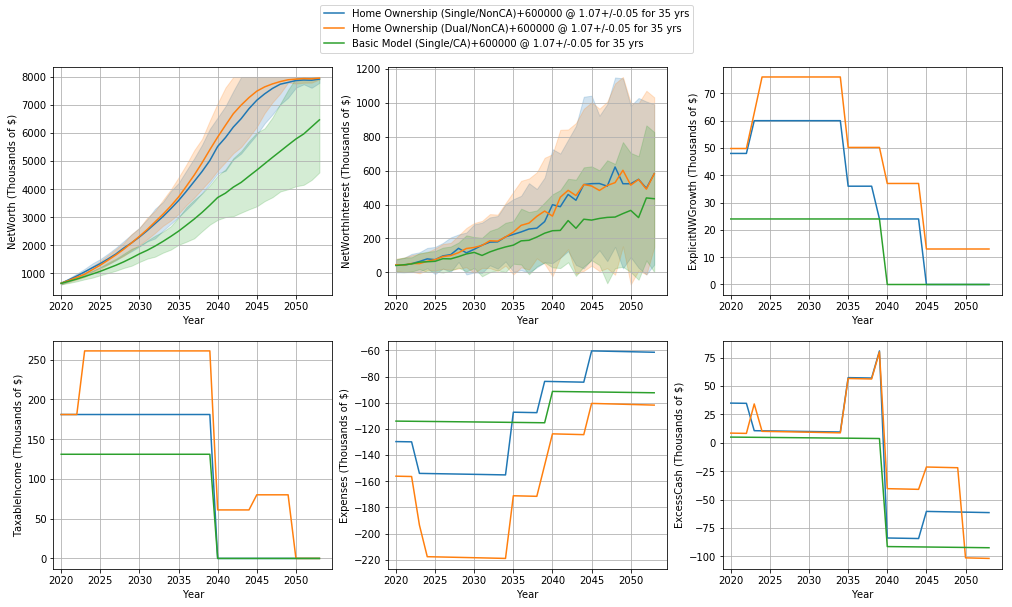

Starting sim for Home Ownership (Single/NonCA)+600000 @ 1.075+/-0.189 for 45 yrs ... Finished in 2.8 seconds
Starting sim for Home Ownership (Dual/NonCA)+600000 @ 1.075+/-0.189 for 45 yrs ... Finished in 2.8 seconds
Starting sim for Basic Model (Single/CA)+600000 @ 1.075+/-0.189 for 45 yrs ... Finished in 2.6 seconds


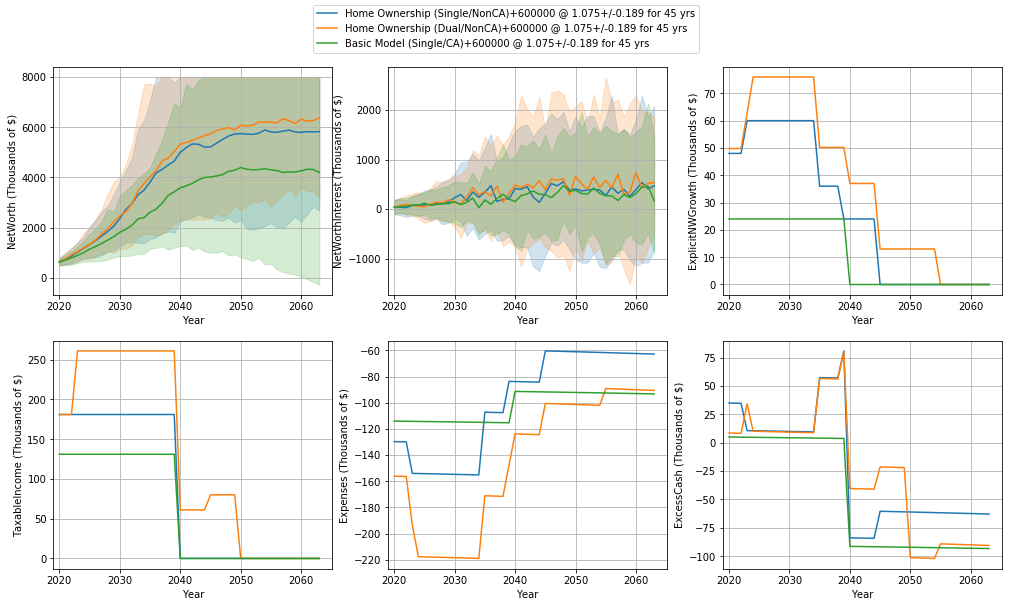

In [88]:
fm = FinancialModel(year=2019)

sim_results = [] # We'll append all sim results to this list for one large fm plot at the end
ho_single = CashflowModel('Home Ownership (Single/NonCA)') #Home Ownership Model (as compared to renting, etc)
cm = ho_single
cm.add_yearly(200000, 'Salary', year_end=20, taxable=True)
cm.add_monthly(-4000, 'Pri. Res.', monthly_nw=2000, year_end=15)
cm.add_monthly(-2000, 'Sec. Res.', monthly_nw=1000, year_start=4, year_end=19)
cm.add_monthly(-800, 'Auto Costs', yearly_apr=1.01) # Two vehicles - car and truck, one as a 'beater'
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000, year_end=25, taxable=True)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000, year_end=25)
cm.add_monthly(-3000, 'Monthly Spend')
cm.add_yearly(-12000, 'Yearly Spend')

ho_dual = CashflowModel('Home Ownership (Dual/NonCA)') #Home Ownership Model (as compared to renting, etc)
cm = ho_dual
cm.add_yearly(200000, 'Salary (A)', year_end=20, taxable=True)
cm.add_yearly(90000, 'Salary (B)', year_start=4, year_end=30, taxable=True)
cm.add_monthly(-4000, 'Pri. Res.', monthly_nw=2150, year_end=15)
cm.add_monthly(-2000, 'Sec. Res.', monthly_nw=1100, year_start=5, year_end=20)
cm.add_monthly(-2000, 'School Loans', year_start=4, year_end=19)
cm.add_monthly(-1000, 'Auto Costs', yearly_apr=1.01) # Mild upgrade to the two vehicles, as both are commuters now
cm.add_yearly(-19000, '401k Savings (A)', yearly_nw=19000, year_end=25, taxable=True)
cm.add_yearly(-10000, '401k Savings (B)', yearly_nw=10000, year_start=4, year_end=35, taxable=True)
cm.add_yearly(-5000, 'IRA Savings (A)', yearly_nw=5000,year_end=25)
cm.add_yearly(-3000, 'IRA Savings (B)', yearly_nw=3000, year_start=4, year_end=35)
cm.add_monthly(-4500, 'Monthly Spend')
cm.add_yearly(-18000, 'Yearly Spend')

renting_single = CashflowModel('Renting Model (Single/CA)', state_tax=ca_tax_rates)
cm = renting_single
cm.add_yearly(330000, 'Salary', year_end=20, taxable=True)
cm.add_monthly(-4500, 'Primary Residence', monthly_nw=0)
cm.add_monthly(-500, 'Auto Costs', yearly_apr=1.01)
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000, year_end=20, taxable=True)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000, year_end=20)
cm.add_monthly(-3500, 'Monthly Spend') # CA is expensive
cm.add_yearly(-15000, 'Yearly Spend') # CA is expensive

basic_single = CashflowModel('Basic Model (Single/CA)', state_tax=ca_tax_rates)
cm = basic_single
cm.add_yearly(150000, 'Salary', year_end=20, taxable=True)
cm.add_monthly(-2500, 'Primary Residence', monthly_nw=0)
cm.add_monthly(-500, 'Auto Costs', yearly_apr=1.01)
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000, year_end=20, taxable=True)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000, year_end=20)
cm.add_monthly(-3500, 'Monthly Spend') # CA is expensive
cm.add_yearly(-12000, 'Yearly Spend')

sim_results = []
nyears = 35
sim_results.append(fm.sim(ho_single, nyears=nyears, initial_nw=600000, nw_apr_avg=1.07, nw_apr_stdev=0.05))
sim_results.append(fm.sim(ho_dual, nyears=nyears, initial_nw=600000, nw_apr_avg=1.07, nw_apr_stdev=0.05))
#sim_results.append(fm.sim(renting_single, nyears=nyears, initial_nw=600000, nw_apr_avg=1.07, nw_apr_stdev=0.05))
sim_results.append(fm.sim(basic_single, nyears=nyears, initial_nw=600000, nw_apr_avg=1.07, nw_apr_stdev=0.05))

#df, df_s = sim_results[0]
#print(df)
# The default suffix is just standard deviation. The :0.80 suffix gives me the 10th and 90th percentile bars on plots
fm.plot(sim_results, suffix=':0.80')

sim_results = []
nyears = 45
# These sims use the default args based on real stock market data over time
sim_results.append(fm.sim(ho_single, nyears=nyears, initial_nw=600000))
sim_results.append(fm.sim(ho_dual, nyears=nyears, initial_nw=600000))
#sim_results.append(fm.sim(renting_single, nyears=nyears, initial_nw=600000))
sim_results.append(fm.sim(basic_single, nyears=nyears, initial_nw=600000))
fm.plot(sim_results, suffix=':0.80')


